#### required libraries

In [2]:
import pandas as pd
import numpy as np
import random
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#### data (all from Kaggle)

In [3]:
population1 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/world-population-by-country-2020.csv')
population2 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/world-rural-population.csv')
economy1 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/Country.csv')
economy2 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/Cost_of_Living_Index_2022.csv')
economy3 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/GDP%20by%20Country%201999-2022.csv')
economy4 = pd.read_csv('https://raw.githubusercontent.com/tinabl/world-K-means/main/Country_data%20(Merged).csv')

### Some regulations to convert the six data frames into more useful forms 

#### These mostly include some modifications on column names and data types, correcting spelling and indexing errors, concats and merges between dataframes. The column name 'country' was made common to five of them for later use.

population1

In [4]:
population1.rename(columns = {'Population 2020':'Population',
                              'Country (or dependency)': 'Country',
                              'Fert. Rate': 'Fertility Rate',
                              'Med. Age': 'Median Age',
                              'Urban Pop %': 'Urban Population (%)',
                              'Migrants (net)': 'Migrants (Net)'}, inplace = True)

population1.replace(',','', regex=True, inplace=True)
population1.replace('%','', regex=True, inplace=True)

population1 = pd.concat([pd.DataFrame([pd.to_numeric(population1[e],errors='coerce') 
                        for e in population1.columns if e not in ['Country']]).T,
                        population1[['Country']]],axis=1)

population1['Population'] = population1['Population'].astype('Int64')
population1['Net Change'] = population1['Net Change'].astype('Int64')
population1['Land Area (Km²)'] = population1['Land Area (Km²)'].astype('Int64')
population1['Migrants (Net)'] = population1['Migrants (Net)'].astype('Int64')
population1['Median Age'] = population1['Median Age'].astype('Int64')
population1['Urban Population (%)'] = population1['Urban Population (%)'].astype('Int64')

del population1["no"]

population1= population1.reset_index(drop=True)

cols = population1.columns.tolist()
cols = cols[-1:] + cols[:-1]
population1 = population1[cols]

In [5]:
population1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               235 non-null    object 
 1   Population            235 non-null    Int64  
 2   Yearly Change         235 non-null    float64
 3   Net Change            235 non-null    Int64  
 4   Density  (P/Km²)      235 non-null    float64
 5   Land Area (Km²)       235 non-null    Int64  
 6   Migrants (Net)        201 non-null    Int64  
 7   Fertility Rate        201 non-null    float64
 8   Median Age            201 non-null    Int64  
 9   Urban Population (%)  222 non-null    Int64  
 10  World Share           235 non-null    float64
dtypes: Int64(6), float64(4), object(1)
memory usage: 21.7+ KB


In [6]:
population1.head(5)

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),World Share
0,China,1439323776,0.39,5540090,153.0,9388211,-348399,1.7,38,61,18.47
1,India,1380004385,0.99,13586631,464.0,2973190,-532687,2.2,28,35,17.70
2,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,4.25
3,Indonesia,273523615,1.07,2898047,151.0,1811570,-98955,2.3,30,56,3.51
4,Pakistan,220892340,2.00,4327022,287.0,770880,-233379,3.6,23,35,2.83


population2

In [7]:
population2=population2[['Country Name', 'Country Code', '2020']]

population2.rename(columns = {'Country Name':'Country',
                              'Country Code':'Code',
                              '2020':'Rural Population'}, inplace = True)

population2['Rural Population'] = population2['Rural Population'].astype('Int64')

population2= population2[population2['Country'].apply(lambda x: len(x) < 25)]

population2= population2.reset_index(drop=True)

In [8]:
population2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           241 non-null    object
 1   Code              241 non-null    object
 2   Rural Population  237 non-null    Int64 
dtypes: Int64(1), object(2)
memory usage: 6.0+ KB


In [9]:
population2.head(5)

,Country,Code,Rural Population
0,Aruba,ABW,60112
1,Afghanistan,AFG,28796851
2,Angola,AGO,10903384
3,Albania,ALB,1075204
4,Andorra,AND,9337


economy1

In [10]:
economy1= economy1[['CountryCode', 'ShortName', 'Region']]

In [11]:
economy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CountryCode  247 non-null    object
 1   ShortName    247 non-null    object
 2   Region       214 non-null    object
dtypes: object(3)
memory usage: 5.9+ KB


In [12]:
economy1.head(5)

,CountryCode,ShortName,Region
0,AFG,Afghanistan,South Asia
1,ALB,Albania,Europe & Central Asia
2,DZA,Algeria,Middle East & North Africa
3,ASM,American Samoa,East Asia & Pacific
4,ADO,Andorra,Europe & Central Asia


economy2

In [13]:
del economy2["Rank"]
del economy2["Cost of Living Plus Rent Index"]
del economy2["Local Purchasing Power Index"]

In [14]:
economy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 139 non-null    object 
 1   Cost of Living Index    139 non-null    float64
 2   Rent Index              139 non-null    float64
 3   Groceries Index         139 non-null    float64
 4   Restaurant Price Index  139 non-null    float64
dtypes: float64(4), object(1)
memory usage: 5.6+ KB


In [15]:
economy2.head(5)

,Country,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index
0,Afghanistan,20.37,2.72,14.92,12.41
1,Albania,35.50,8.47,29.32,25.82
2,Algeria,26.87,4.59,28.82,14.48
3,Argentina,34.69,7.71,28.17,33.32
4,Armenia,33.89,11.61,27.59,30.55


economy3

In [16]:
economy3=economy3[['Country', '2022']]
economy3.columns = economy3.columns.str.replace('2022', 'GDP (2022)')

economy3['GDP (2022)']= pd.to_numeric(economy3['GDP (2022)'], errors='coerce')
economy3['GDP (2022)'].replace(',','', regex=True, inplace=True)

In [17]:
economy3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     180 non-null    object 
 1   GDP (2022)  163 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


In [18]:
economy3.head(5)

,Country,GDP (2022)
0,"Afghanistan, Rep. of.",0.000
1,Albania,18.012
2,Algeria,168.195
3,Angola,74.953
4,Antigua and Barbuda,1.534


economy4

In [19]:
economy4=economy4[['name','region','gini','growthRate','birthRate','infantMortalityRate','lifeExpectancy',
                   'inflation','unemployment','agricultureLabour','servicesLabour','industryLabour',]]

economy4.rename(columns = {'name': 'Country',
                           'region': 'Region',
                            'gini': 'Gini Index',
                            'growthRate': 'Growth Rate',
                            'birthRate': 'Birth Rate',
                            'infantMortalityRate': 'Infant Mortality Rate',
                            'lifeExpectancy': 'Life Expectancy',
                            'inflation': 'Inflation (2020)',
                            'unemployment': 'Unemployment',
                            'agricultureLabour': 'Agriculture Labour',
                            'servicesLabour': 'Services Labour',
                            'industryLabour': 'Industry Labour'}, inplace = True)

economy4.replace('%','', regex=True, inplace=True)
economy4.replace('/1000','', regex=True, inplace=True)

economy5= economy4[['Country', 'Region']]
del economy4["Region"]

economy4 = pd.concat([pd.DataFrame([pd.to_numeric(economy4[e],errors='coerce') 
                    for e in economy4.columns if e not in ['Country']]).T,
                    economy4[['Country']]],axis=1)

economy4=pd.merge(economy4, economy5)

In [20]:
economy4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gini Index             153 non-null    float64
 1   Growth Rate            165 non-null    float64
 2   Birth Rate             179 non-null    float64
 3   Infant Mortality Rate  180 non-null    float64
 4   Life Expectancy        181 non-null    float64
 5   Inflation (2020)       166 non-null    float64
 6   Unemployment           154 non-null    float64
 7   Agriculture Labour     143 non-null    float64
 8   Services Labour        141 non-null    float64
 9   Industry Labour        140 non-null    float64
 10  Country                250 non-null    object 
 11  Region                 248 non-null    object 
dtypes: float64(10), object(2)
memory usage: 25.4+ KB


In [21]:
economy4.head(5)

,Gini Index,Growth Rate,Birth Rate,Infant Mortality Rate,Life Expectancy,Inflation (2020),Unemployment,Agriculture Labour,Services Labour,Industry Labour,Country,Region
0,27.8,2.30,38.80,117.23,50.49,6.8,35.0,80.0,10.0,10.0,Afghanistan,Asia
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Åland Islands,Europe
2,34.5,0.30,12.73,13.19,77.96,1.7,16.9,54.0,32.6,12.8,Albania,Europe
3,35.3,1.88,23.99,21.76,76.39,3.9,10.3,14.0,NaN,13.4,Algeria,Africa
4,NaN,NaN,22.87,8.92,74.91,NaN,29.8,NaN,NaN,NaN,American Samoa,Oceania


### Binary merging process of the dataframes

#### The aim of this section is to create a huge dataframe called 'world' by using all dataframes one by one except economy1. I did this using the Fuzzywuzzy library through the 'country' columns created in all of them. String matching by Fuzzywuzzy gave good results, but to get a better result, I had to examine all the data and made specific changes.

world1

In [22]:
temp1 = [x for x in set(population1['Country']) if x not in set(population2['Country'])]
temp2 = [x for x in set(population2['Country']) if x not in set(population1['Country'])]

for i, j in enumerate(temp2):
    n= 70
    for k in temp1:
        m= fuzz.partial_ratio(j, k)
        if n<=m and m>70:
            population2.replace(j, k, inplace=True)
            n= fuzz.partial_ratio(j, k)

In [23]:
population2.replace('Korea, Rep.', 'South Korea', inplace=True)
population2.replace('Kyrgyz Republic', 'Kyrgyzstan', inplace=True)

duppyrows= ['COG', 'CUW', 'SSF', 'TCA']
population2 = population2[population2.Code.isin(duppyrows) == False]

In [24]:
world1= pd.merge(population1, population2, on='Country', how='left')
world1.head(5)

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),World Share,Code,Rural Population
0,China,1439323776,0.39,5540090,153.0,9388211,-348399,1.7,38,61,18.47,CHN,544223674
1,India,1380004385,0.99,13586631,464.0,2973190,-532687,2.2,28,35,17.70,IND,898024053
2,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,4.25,USA,57469027
3,Indonesia,273523615,1.07,2898047,151.0,1811570,-98955,2.3,30,56,3.51,IDN,118597107
4,Pakistan,220892340,2.00,4327022,287.0,770880,-233379,3.6,23,35,2.83,PAK,138797696


world2

In [25]:
temp1 = [x for x in set(population1['Country']) if x not in set(economy2['Country'])]
temp2 = [x for x in set(economy2['Country']) if x not in set(population1['Country'])]

for i, j in enumerate(temp2):
    n= 70
    for k in temp1:
        m= fuzz.partial_ratio(j, k)
        if n<=m and m>70:
            economy2.replace(j, k, inplace=True)
            n= fuzz.partial_ratio(j, k)

In [26]:
world2= pd.merge(world1, economy2, on='Country', how='left')
world2.head(5)

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),World Share,Code,Rural Population,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index
0,China,1439323776,0.39,5540090,153.0,9388211,-348399,1.7,38,61,18.47,CHN,544223674,41.77,16.53,46.01,28.37
1,India,1380004385,0.99,13586631,464.0,2973190,-532687,2.2,28,35,17.70,IND,898024053,24.43,5.30,26.43,17.56
2,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,4.25,USA,57469027,70.13,42.07,70.37,70.07
3,Indonesia,273523615,1.07,2898047,151.0,1811570,-98955,2.3,30,56,3.51,IDN,118597107,35.85,9.82,38.29,17.74
4,Pakistan,220892340,2.00,4327022,287.0,770880,-233379,3.6,23,35,2.83,PAK,138797696,19.92,3.91,17.81,15.54


world3

In [27]:
temp1 = [x for x in set(population1['Country']) if x not in set(economy3['Country'])]
temp2 = [x for x in set(economy3['Country']) if x not in set(population1['Country'])]

for i, j in enumerate(temp2):
    n= 70
    for k in temp1:
        m= fuzz.partial_ratio(j, k)
        if n<=m and m>70:
            economy3.replace(j, k, inplace=True)
            n= fuzz.partial_ratio(j, k)

In [28]:
economy3.replace('Kyrgyz Republic', 'Kyrgyzstan', inplace=True)
economy3.replace('Swaziland', 'Eswatini', inplace=True)

economy3.drop([37], axis=0, inplace=True)

In [29]:
world3= pd.merge(world1, economy3, on='Country', how='left')
world3.head(5)

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),World Share,Code,Rural Population,GDP (2022)
0,China,1439323776,0.39,5540090,153.0,9388211,-348399,1.7,38,61,18.47,CHN,544223674,NaN
1,India,1380004385,0.99,13586631,464.0,2973190,-532687,2.2,28,35,17.70,IND,898024053,NaN
2,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,4.25,USA,57469027,NaN
3,Indonesia,273523615,1.07,2898047,151.0,1811570,-98955,2.3,30,56,3.51,IDN,118597107,NaN
4,Pakistan,220892340,2.00,4327022,287.0,770880,-233379,3.6,23,35,2.83,PAK,138797696,0.0


world

In [30]:
temp1 = [x for x in set(population1['Country']) if x not in set(economy4['Country'])]
temp2 = [x for x in set(economy4['Country']) if x not in set(population1['Country'])]

for i, j in enumerate(temp2):
    n= 70
    for k in temp1:
        m= fuzz.partial_ratio(j, k)
        if n<=m and m>70:
            economy4.replace(j, k, inplace=True)
            n= fuzz.partial_ratio(j, k)

In [31]:
economy4.drop([1, 30, 33, 34, 187, 191, 233], axis=0, inplace=True)

economy4.replace("Korea (Democratic People's Republic of)", 'North Korea', inplace=True)
economy4.replace('Korea (Republic of)', 'South Korea', inplace=True)
economy4.replace('Swaziland', 'Eswatini', inplace=True)

In [32]:
world= pd.merge(world1, economy4, on='Country', how='left')

In [33]:
world.head(10)

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),...,Growth Rate,Birth Rate,Infant Mortality Rate,Life Expectancy,Inflation (2020),Unemployment,Agriculture Labour,Services Labour,Industry Labour,Region
0,China,1439323776,0.39,5540090,153.0,9388211,-348399,1.7,38,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
1,India,1380004385,0.99,13586631,464.0,2973190,-532687,2.2,28,35,...,1.25,19.89,43.19,67.80,9.6,8.8,49.0,31.0,20.0,Asia
2,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oceania
3,United States,331002651,0.59,1937734,36.0,9147420,954806,1.8,38,83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Americas
4,Indonesia,273523615,1.07,2898047,151.0,1811570,-98955,2.3,30,56,...,0.95,17.04,25.16,72.17,7.7,6.6,38.9,47.9,13.2,Asia
5,Pakistan,220892340,2.00,4327022,287.0,770880,-233379,3.6,23,35,...,1.49,23.19,57.48,67.05,7.7,6.6,45.1,34.2,20.7,Asia
6,Brazil,212559417,0.72,1509890,25.0,8358140,21200,1.7,33,88,...,1.10,17.48,NaN,72.79,6.5,6.0,20.0,66.0,14.0,Americas
7,Nigeria,206139589,2.58,5175990,226.0,910770,-60000,5.4,18,52,...,2.47,38.03,74.09,52.62,8.7,23.9,70.0,20.0,10.0,Africa
8,Bangladesh,164689383,1.01,1643222,1265.0,130170,-369501,2.1,28,39,...,1.60,21.61,45.67,70.65,7.6,5.0,47.0,40.0,13.0,Asia
9,Russia,145934462,0.04,62206,9.0,16376870,182456,1.8,40,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe


In [34]:
world.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                240 non-null    object 
 1   Population             240 non-null    Int64  
 2   Yearly Change          240 non-null    float64
 3   Net Change             240 non-null    Int64  
 4   Density  (P/Km²)       240 non-null    float64
 5   Land Area (Km²)        240 non-null    Int64  
 6   Migrants (Net)         206 non-null    Int64  
 7   Fertility Rate         206 non-null    float64
 8   Median Age             206 non-null    Int64  
 9   Urban Population (%)   227 non-null    Int64  
 10  World Share            240 non-null    float64
 11  Code                   213 non-null    object 
 12  Rural Population       211 non-null    Int64  
 13  Gini Index             153 non-null    float64
 14  Growth Rate            164 non-null    float64
 15  Birth 

### Splitting 'world' into five continents dataframes

#### 'Asia', 'Europe' and 'Africa' already existed in the 'region' column of the 'world' and were easily pulled, but America was not divided into north and south as in the plotly.express.choropleth library. An effort to obtain 'north_america' and 'south_america' datasets from 'americas' with merging economy1 is given below along with the other three.

In [35]:
asia= world[world['Region'].apply(lambda x: x == 'Asia')]
europe= world[world['Region'].apply(lambda x: x == 'Europe')]
africa= world[world['Region'].apply(lambda x: x == 'Africa')]
americas= world[world['Region'].apply(lambda x: x == 'Americas')]

In [36]:
ec1short= economy1[economy1['Region'].apply(lambda x: x == 'Latin America & Caribbean' or x == 'North America')]

In [37]:
ec1short.loc[ec1short['Region'] == 'Latin America & Caribbean', 'Region'] = 'South America'

C:\Users\tina\AppData\Local\Temp\ipykernel_15856\44289489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ec1short.loc[ec1short['Region'] == 'Latin America & Caribbean', 'Region'] = 'South America'


In [38]:
ec1short.rename(columns = {'CountryCode':'Code'}, inplace = True)

C:\Users\tina\AppData\Local\Temp\ipykernel_15856\2385047233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ec1short.rename(columns = {'CountryCode':'Code'}, inplace = True)


In [39]:
del americas["Region"]
americas= pd.merge(americas, ec1short, on='Code', how='left')
americas.loc[americas['Country'] == 'Mexico', 'Region'] = 'North America'

In [40]:
for j in ['Mexico', 'Guatemala', 'Haiti', 'Cuba', 'Dominican Republic', 'Honduras', 'Nicaragua', 'Costa Rica',\
          'Panama', 'El Salvador', 'Jamaica', 'Puerto Rico', 'Trinidad and Tobago', 'Guade', 'Belize', 'The Bahamas',\
          'Martinique', 'Greenland', 'Sint Maarten', 'Turks and Caicos']:
    americas.loc[americas['Country'] == j, 'Region'] = 'North America'

for j in ['French Guiana', 'Barbados', 'Greenland', 'Falkland Islands']:
    americas.loc[americas['Country'] == j, 'Region'] = 'South America'

In [41]:
north_america= americas[americas['Region'].apply(lambda x: x == 'North America')]
south_america= americas[americas['Region'].apply(lambda x: x == 'South America')]

### Correlation matrix of 'world' and it's heatmap

#### As dividing the maps, the selected 'world' columns being approximate to each other will enable the K-means algorithm to produce more meaningful outputs. Data to easily see the closeness:

In [42]:
world.corr()

,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (Net),Fertility Rate,Median Age,Urban Population (%),World Share,...,Gini Index,Growth Rate,Birth Rate,Infant Mortality Rate,Life Expectancy,Inflation (2020),Unemployment,Agriculture Labour,Services Labour,Industry Labour
Population,1.000000,-0.013638,0.852481,-0.027986,0.473857,-0.166334,-0.057209,0.027529,-0.023616,0.999999,...,-0.007942,0.007550,-0.016365,0.105291,-0.063493,0.167197,-0.062741,0.100781,-0.105163,-0.026273
Yearly Change,-0.013638,1.000000,0.188109,-0.027099,0.001371,-0.033784,0.823656,-0.843869,-0.277948,-0.013609,...,0.264251,0.614946,0.024948,0.729797,-0.665558,0.348623,0.280013,0.748162,-0.618078,-0.431773
Net Change,0.852481,0.188109,1.000000,-0.036534,0.321187,-0.224152,0.158815,-0.186185,-0.134952,0.852340,...,-0.026790,0.115988,-0.008365,0.247680,-0.200231,0.253254,-0.008728,0.238384,-0.231302,-0.107328
Density (P/Km²),-0.027986,-0.027099,-0.036534,1.000000,-0.061241,-0.005163,-0.149751,0.139641,0.036275,-0.027885,...,0.111184,-0.093516,-0.024579,-0.125098,0.224323,-0.063421,-0.093422,-0.127635,0.138062,0.072045
Land Area (Km²),0.473857,0.001371,0.321187,-0.061241,1.000000,0.334302,-0.059129,0.075213,0.131113,0.473913,...,0.040919,0.045163,-0.025748,0.119064,-0.071799,0.201274,-0.058670,0.019831,0.015949,-0.074706
Migrants (Net),-0.166334,-0.033784,-0.224152,-0.005163,0.334302,1.000000,-0.120292,0.192437,0.263749,-0.166088,...,0.023338,-0.057578,-0.012350,-0.211099,0.168571,-0.185378,-0.025132,-0.225201,0.224506,0.142849
Fertility Rate,-0.057209,0.823656,0.158815,-0.149751,-0.059129,-0.120292,1.000000,-0.883392,-0.493009,-0.057367,...,0.214483,0.553598,0.063166,0.866367,-0.817644,0.340945,0.431375,0.842525,-0.746288,-0.395677
Median Age,0.027529,-0.843869,-0.186185,0.139641,0.075213,0.192437,-0.883392,1.000000,0.539091,0.027640,...,-0.387398,-0.612411,-0.078298,-0.805295,0.800537,-0.412489,-0.350757,-0.810747,0.734219,0.452759
Urban Population (%),-0.023616,-0.277948,-0.134952,0.036275,0.131113,0.263749,-0.493009,0.539091,1.000000,-0.023437,...,-0.080999,-0.225656,-0.032752,-0.502168,0.495821,-0.216589,-0.166698,-0.637010,0.605973,0.223755
World Share,0.999999,-0.013609,0.852340,-0.027885,0.473913,-0.166088,-0.057367,0.027640,-0.023437,1.000000,...,-0.007796,0.007684,-0.016458,0.105222,-0.063448,0.167156,-0.062919,0.100680,-0.105090,-0.026228


<AxesSubplot:>

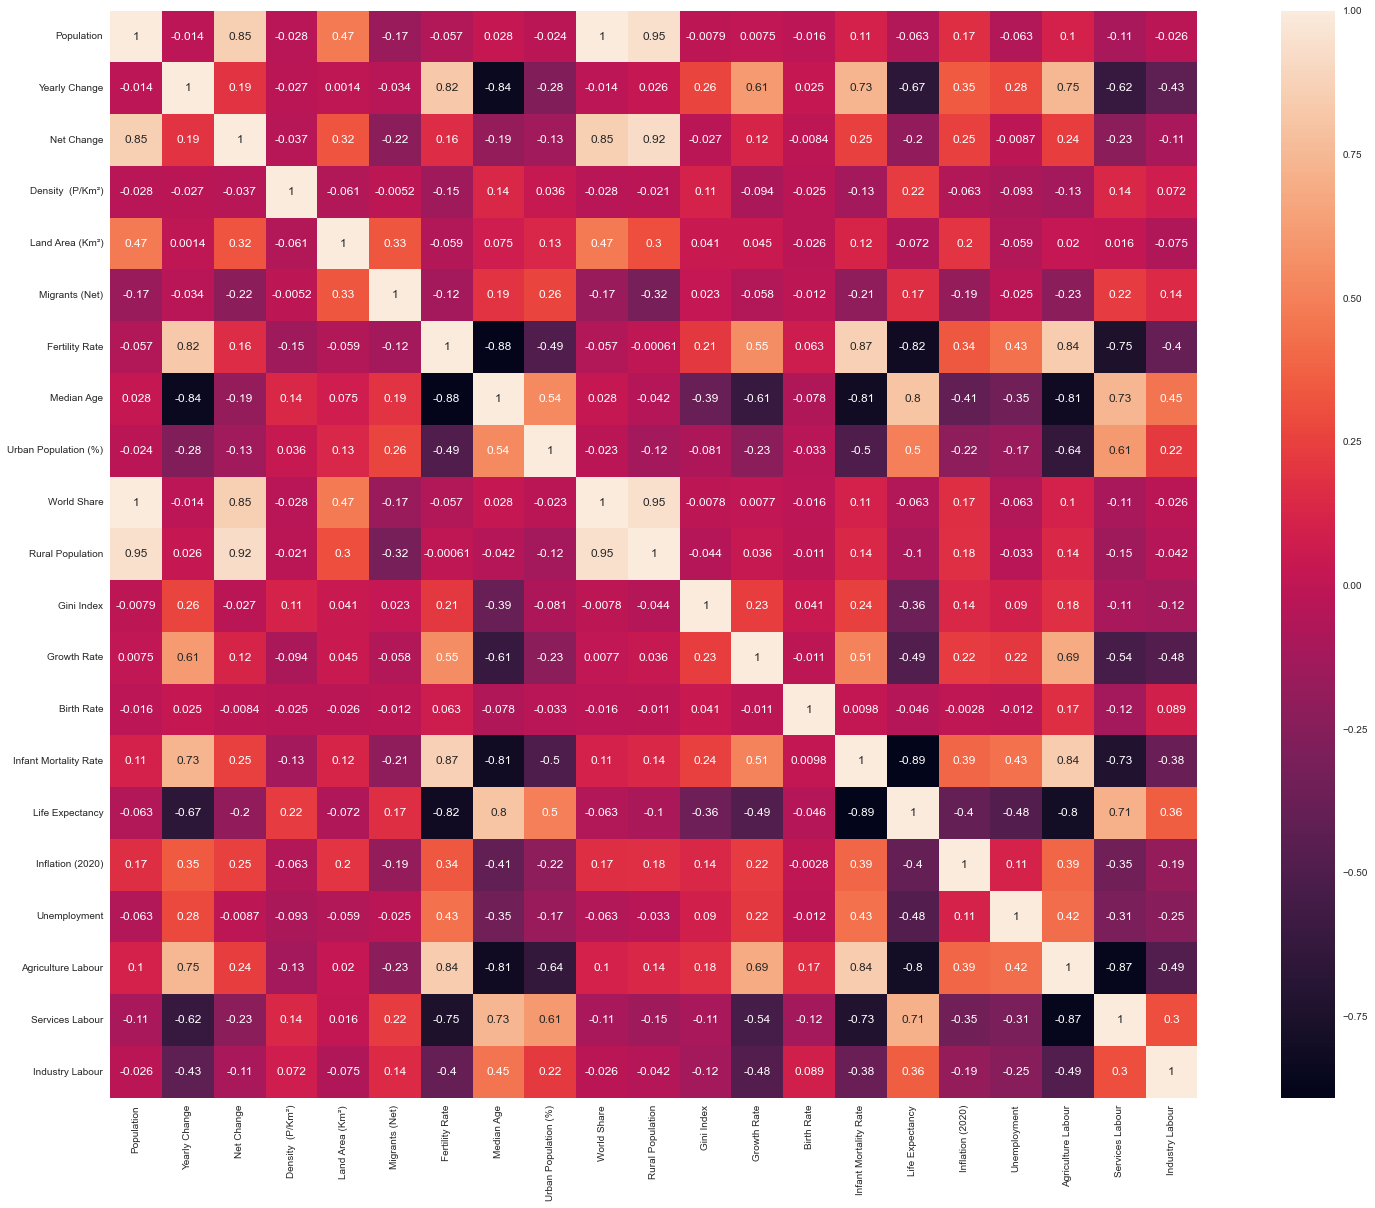

In [43]:
fig=plt.figure(figsize=(30,20))
sns.heatmap(world.corr(), annot=True, square=True)

### Dividing the world map or continent maps according to the parameters we choose

#### 'column_list' is the list of numeric columns of 'world'. Selecting some of them will create the list of 'lst' whose  elements will be collectively one parameter to K-means clustering. After this, we need to select the region we will work with from the 'dict' elements, and k which indicates how many we will divide it into. KElbowVisualizer calculates the k parameter for which the K-means algorithm will give the optimal result. This is the point where the distortion is highest.

In [53]:
lst=['Country']
while True:
    choice = input(">")
    lst.append(choice.title())
    if choice == 'b':
        lst.remove('B')
        break

>population
>fertility rate
>b


In [51]:
lst

['Country', 'Poulation', 'Fertility Rate']

In [54]:
dct= {'africa': africa, 'asia': asia, 'europe': europe, 'south america': south_america,\
      'north america': north_america, 'world': world}

In [56]:
region = input('Choose from list: ')

Choose from list: world


In [57]:
nested_list= []

for i, j in enumerate(lst):
    l= list(dct[region][j])
    nested_list.append(l)
    
df = pd.DataFrame(nested_list).T
df.columns= lst
df=df.dropna()
df2= df.drop(['Country'], axis=1)

world_scaled = StandardScaler().fit_transform(df2)

C:\Users\tina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


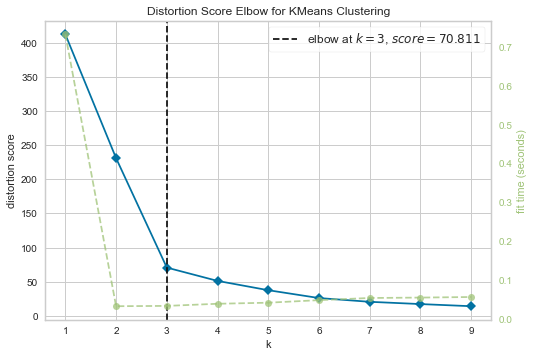

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(world_scaled)
visualize.poof()

Number of clusters: 3


C:\Users\tina\AppData\Local\Temp\ipykernel_15856\1959929074.py:6: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.



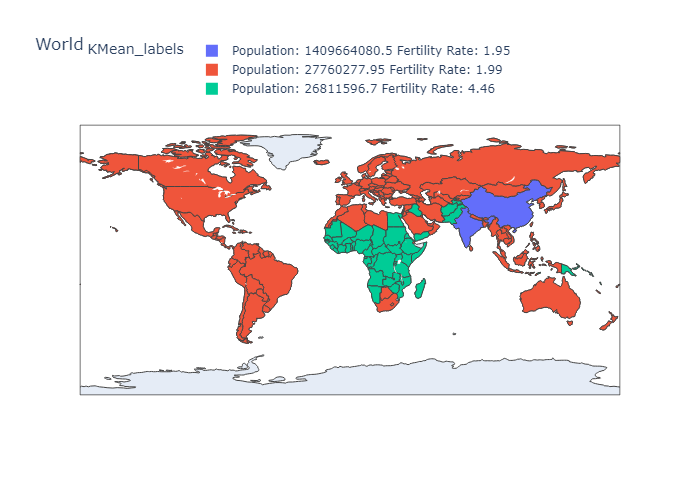

In [78]:
k= int(input('Number of clusters: '))
model = KMeans(n_clusters=k, random_state=1)
model.fit(world_scaled)
df['KMean_labels']=model.labels_

df_groupby= df.groupby(['KMean_labels']).mean()
cat = {}
lst.remove('Country')


for k in range(k):
    cat[k]=''

for k in range(k+1):
    for i, j in enumerate(lst):
        new_list = [round(item, 2) for item in list(df_groupby[j])]
        #j= j.replace('_', ' ')
        #j= j.title()
        p= new_list[k]
        s= j+': '+ str(p)+ '\n'
        cat[k]= cat[k] + s
       
lst.append('Country')

df['KMean_labels']=df['KMean_labels'].map(cat)

k += 1

title= region.title()
fig= px.choropleth(df, locationmode='country names', locations='Country', color=df['KMean_labels'], 
                   color_continuous_scale=[(0, "pink"), (0.5, "blue"), (1, "purple")], scope=region, title=title)

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.99,
    xanchor='left',
    x=0.01
))
fig.update_layout(legend_orientation='h')
fig.show('png')


In [66]:
!pip install -U kaleido

In [72]:
import plotly.io as pio
pio.renderers.default = "png"

In [71]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'svg'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [74]:
conda install -c plotly plotly-orca

^C

Note: you may need to restart the kernel to use updated packages.


In [75]:
!conda install -c plotly plotly-orca

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0




In [76]:
conda update -n base -c defaults conda

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\tina\anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-package-handling-2.2.0|   py39haa95532_0         287 KB
    conda-package-streaming-0.9.0|   py39haa95532_0          29 KB
    pyjwt-2.4.0                |   py39haa95532_0          38 KB
    zstandard-0.19.0           |   py39h2bbff1b_0         340 KB
    ------------------------------------------------------------
                                           Total:         693 KB

The following NEW packages will be INSTALLED:

  conda-package-str~ pkgs/main/win-64::conda-package-streaming-0.9.0-py39haa95532_0 
  zstandard          pkgs/main/win-64::zstandard-0.19.0-py39h2bbff1b_0 

The following packages will be UPDATED:

  conda-package-han~                   1.8.1-py39h8cc25b3_0 --> 2.2



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0




In [ ]:
conda install -c plotly plotly-orca==1.2.1 psutil requests

In [ ]:
conda install -c conda-forge python-kaleido

In [ ]:
$ conda install -c conda-forge python-kaleido

In [77]:
conda install -c conda-forge python-kaleido

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\tina\anaconda3

  added / updated specs:
    - python-kaleido


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kaleido-core-0.2.1         |       h8ffe710_0        57.6 MB  conda-forge
    mathjax-2.7.7              |       h57928b3_3        21.2 MB  conda-forge
    python-kaleido-0.2.1       |     pyhd8ed1ab_0          18 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        78.8 MB

The following NEW packages will be INSTALLED:

  kaleido-core       conda-forge/win-64::kaleido-core-0.2.1-h8ffe710_0 
  mathjax            conda-forge/win-64::mathjax-2.7.7-h57928b3_3 
  python-kaleido     conda-forge/noarch::python-kaleido-0.2.1-pyhd8ed1ab_0 




mathjax-2.7.7        | 21.2 MB   |            |   0% 

python-kalei



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0






kaleido-core-0.2.1   | 57.6 MB   | 7          |   8% 
mathjax-2.7.7        | 21.2 MB   | ####9      |  49% 


kaleido-core-0.2.1   | 57.6 MB   | 8          |   8% 
mathjax-2.7.7        | 21.2 MB   | #####1     |  52% 


kaleido-core-0.2.1   | 57.6 MB   | 8          |   9% 
mathjax-2.7.7        | 21.2 MB   | #####3     |  54% 


kaleido-core-0.2.1   | 57.6 MB   | 9          |   9% 
mathjax-2.7.7        | 21.2 MB   | #####5     |  56% 


kaleido-core-0.2.1   | 57.6 MB   | 9          |  10% 
mathjax-2.7.7        | 21.2 MB   | #####8     |  59% 
mathjax-2.7.7        | 21.2 MB   | ######1    |  61% 


kaleido-core-0.2.1   | 57.6 MB   | #          |  10% 
mathjax-2.7.7        | 21.2 MB   | ######3    |  63% 


kaleido-core-0.2.1   | 57.6 MB   | #1         |  11% 
mathjax-2.7.7        | 21.2 MB   | ######5    |  65% 


kaleido-core-0.2.1   | 57.6 MB   | #1         |  12% 
mathjax-2.7.7        | 21.2 MB   | ######7    |  67% 


kaleido-core-0.2.1   | 57.6 MB   | #2         |  12% 
mathjax-2.